<div style="text-align:center">
    <h1 style="text-align:center; font-size:50px; margin-bottom: 5px">Statistics about the fiducial simulation</h1>
    <p style="text-align:center;">This notebook computes the statistics that we quote in the paper such as the detection rate and fraction of the population that is eccentric</p>
</div>

In [1]:
# general package imports
import h5py as h5
import numpy as np
import astropy.units as u
import seaborn as sns
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord

from scipy.interpolate import interp1d
from scipy.integrate import quad

# custom LISA package
import legwork

import uncertainties as unc

In [2]:
# config stuff to make plots look pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [3]:
# define what DCOs we are working with and a colour scheme
dco_types = ["BHBH", "BHNS", "NSNS"]

# IMPORTANT: these need to point to the folders where you stored the data from Zenodo
data_folder = "../../simulation/data/"
sim_folder = data_folder + "simulation_high_res_double/"

detections_4yr = np.load(data_folder + "detections_4yr.npy")
detections_10yr = np.load(data_folder + "detections_10yr.npy")

In [4]:
detectable_harmonics, snr_uncertainty, ecc_uncertainty, max_harmonics = unc.get_ecc_uncertainty(harmonic_threshold=3, model="fiducial", t_obs=4*u.yr)

# Distribution features
Here we compute fractions of different properties in certain regimes for use in the results section.

In [5]:
for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        data = full_data[snr_mask]

    if dco_type == "BHNS":
        mBH = np.maximum(data["m_1"], data["m_2"])
        mNS = np.minimum(data["m_1"], data["m_2"])
        mass_weights = data["weight"]
        mass_seeds = data["seed"]
    elif dco_type == "BHBH":
        mBH = np.concatenate((data["m_1"], data["m_2"]))
        mNS = None
        mass_weights = np.concatenate((data["weight"], data["weight"]))
        mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
    elif dco_type == "NSNS":
        mNS = np.concatenate((data["m_1"], data["m_2"]))
        mBH = None
        mass_weights = np.concatenate((data["weight"], data["weight"]))
        mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        
    q = data["m_2"] / data["m_1"]
    q[q > 1] = 1 / q[q > 1]
    
    print(dco_type)
    print("======")
    if mBH is not None:
        print("mBH < 11\t", (np.sum(mass_weights[mBH < 11]) / np.sum(mass_weights)).round(2))
        print("mBH mass gap\t", (np.sum(mass_weights[np.logical_and(mBH > 2, mBH < 5)]) / np.sum(mass_weights)).round(2))
    print("q > 0.8\t\t", (np.sum(data["weight"][q > 0.8]) / np.sum(data["weight"])).round(2))
    
    print()
    print("e < 0.01\t", (np.sum(data["weight"][data["e_LISA"] < 0.01]) / np.sum(data["weight"])).round(2))
    print("e > 0.01\t", (np.sum(data["weight"][data["e_LISA"] > 0.01]) / np.sum(data["weight"])).round(2))
    print("e > 0.3\t\t", (np.sum(data["weight"][data["e_LISA"] > 0.3]) / np.sum(data["weight"])).round(2))
    
    print()
    print("tau < 2 Gyr\t", (np.sum(data["weight"][data["tau"] < 2]) / np.sum(data["weight"])).round(2))
    print()

BHBH
mBH < 11	 0.88
mBH mass gap	 0.35
q > 0.8		 0.09

e < 0.01	 0.14
e > 0.01	 0.86
e > 0.3		 0.2

tau < 2 Gyr	 0.56

BHNS
mBH < 11	 0.91
mBH mass gap	 0.39
q > 0.8		 0.0

e < 0.01	 0.54
e > 0.01	 0.46
e > 0.3		 0.08

tau < 2 Gyr	 0.39

NSNS
q > 0.8		 0.89

e < 0.01	 0.14
e > 0.01	 0.86
e > 0.3		 0.12

tau < 2 Gyr	 0.68



# Distinguishing detections

Here we compute the fraction of detections that can be distinguished in different ways

In [6]:
mc_wd = legwork.utils.chirp_mass(1.44, 1.44) * u.Msun
mc_ns = legwork.utils.chirp_mass(2.5, 2.5) * u.Msun

In [7]:
t_obs = 4 * u.yr

for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        data = full_data[snr_mask]

    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                  a=data["a_LISA"] * u.AU)
    
    m_c = legwork.utils.chirp_mass(data["m_1"] * u.Msun, data["m_2"] * u.Msun)
    
    sigma_theta = unc.sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)
    f_orb_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
    f_orb_dot_u = unc.get_f_orb_dot_uncertainty(data["snr"], t_obs, f_orb_dot)
    
    f_orb_u = unc.get_f_orb_uncertainty(data["snr"], t_obs, f_orb_LISA)
    
    D_Mc = unc.get_m_c_uncertainty(f_orb_LISA * max_harmonics[dco_type], f_orb_dot * max_harmonics[dco_type], data["e_LISA"], ecc_uncertainty[dco_type], data["snr"], t_obs).decompose()
    
    WDWD_limit = m_c > mc_wd + (2 * D_Mc * m_c)
    NSNS_difference = np.abs(m_c - mc_ns)
    NSNS_limit = NSNS_difference > 2 * D_Mc * m_c
    
    resolved_in_disc = np.repeat(True, len(data))
    z_scale_thick = 0.95 * u.kpc
    far_enough = data["dist"] > z_scale_thick.value
    another_angle = np.arcsin(z_scale_thick / (data["dist"][far_enough] * u.kpc)).to(u.deg)

    resolved_in_disc[far_enough] = sigma_theta[far_enough] < another_angle
    
    eccentric = detectable_harmonics[dco_type] != 1
    ecc_and_in_disc = np.logical_and(eccentric, resolved_in_disc)
    not_WDWD = np.logical_or(WDWD_limit, ecc_and_in_disc)
    
    limits = [("m_c > WDWD", WDWD_limit), ("eccentric", eccentric), ("in disc", resolved_in_disc),
              ("ecc + disc", ecc_and_in_disc), ("not WDWD", not_WDWD),
              ("BH or NS", NSNS_limit)]

    print(dco_type)
    print("========")
    for label, mask in limits:
        fraction = np.sum(data["weight"][mask]) / np.sum(data["weight"])
        if t_obs == 10 * u.yr:
            print("{}:\t\t fraction={:1.2f}, detections={:1.0f}".format(label, fraction, fraction * np.mean(detections_10yr[i][0])))
        else:
            print("{}:\t\t fraction={:1.2f}, detections={:1.0f}".format(label, fraction, fraction * np.mean(detections_4yr[i][0])))
            
    print()

BHBH
m_c > WDWD:		 fraction=0.17, detections=6
eccentric:		 fraction=0.55, detections=20
in disc:		 fraction=0.54, detections=19
ecc + disc:		 fraction=0.40, detections=14
not WDWD:		 fraction=0.45, detections=16
BH or NS:		 fraction=0.15, detections=6

BHNS
m_c > WDWD:		 fraction=0.20, detections=7
eccentric:		 fraction=0.27, detections=9
in disc:		 fraction=0.68, detections=22
ecc + disc:		 fraction=0.24, detections=8
not WDWD:		 fraction=0.36, detections=12
BH or NS:		 fraction=0.12, detections=4

NSNS
m_c > WDWD:		 fraction=0.03, detections=0
eccentric:		 fraction=0.65, detections=5
in disc:		 fraction=0.87, detections=7
ecc + disc:		 fraction=0.59, detections=5
not WDWD:		 fraction=0.59, detections=5
BH or NS:		 fraction=0.34, detections=3



# SKA Joint Detections
## Working out the SKA area

For our estimates, we need to know the sky area that SKA covers. Keane+15 gives that the area is $|b| < 10$ and $\delta < 45$. Let's visualise that.

In [8]:
b = np.repeat(10, 2000) * u.deg
l = np.linspace(0, 360, 2000) * u.deg

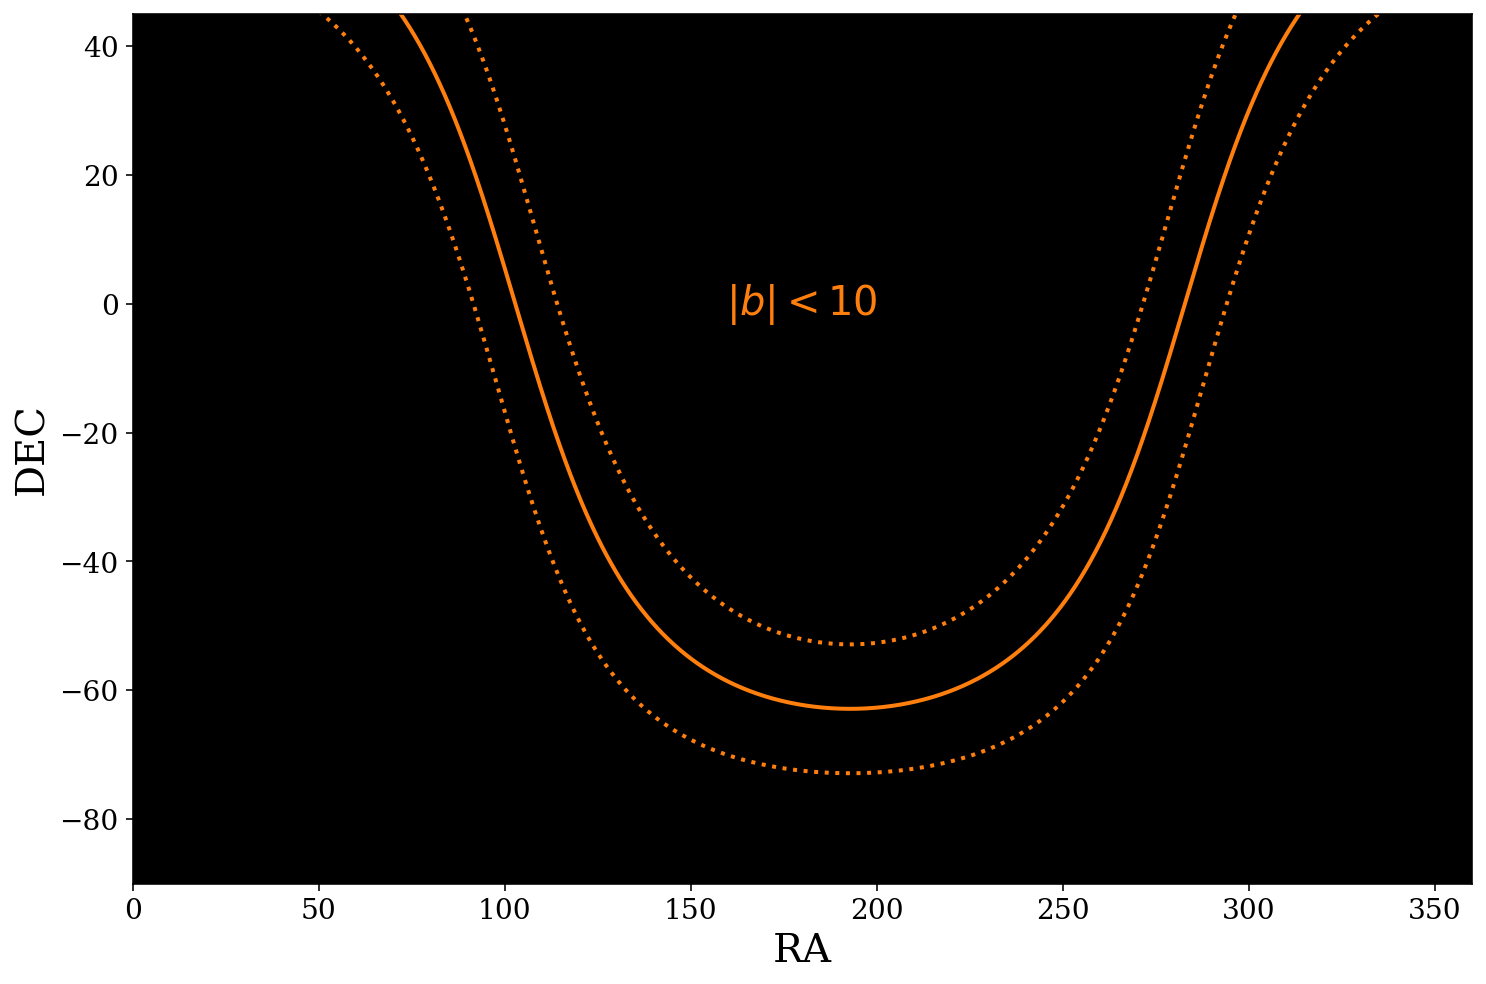

In [9]:
for sign in [-1, 0, 1]:
    x = SkyCoord(l=l, b=b * sign, frame="galactic").transform_to("icrs")
    ra = np.asarray(x.ra)
    dec = np.asarray(x.dec)
    
    order = np.argsort(ra)
    ra = ra[order]
    dec = dec[order]
    
    plt.plot(ra, dec, lw=2, color="tab:orange", linestyle="dotted" if sign != 0 else "-")
    
plt.annotate(r"$\vert b \vert < 10$", xy=(180, 0), color="tab:orange", fontsize=20, ha="center", va="center")

plt.xlim(0, 360)
plt.ylim(-90, 45)

plt.xlabel("RA")
plt.ylabel("DEC")

plt.gca().set_facecolor("black")

plt.show()

## Calculate the enclosed area

In [10]:
# make a huge area of galactic coordinates
l = np.linspace(0, 2 * np.pi, 100000)
bs = ([-10, 10] * u.deg).to(u.rad)

# store them as RA DEC here
limits = np.zeros((2, len(l)))
ras = np.zeros((2, len(l)))

for i, b in enumerate(bs):
    galactic = SkyCoord(l=l, b=np.repeat(b, len(l)), frame="galactic", unit="rad")
    icrs = galactic.transform_to("icrs")

    ra = icrs.ra.to(u.rad)
    dec = icrs.dec.to(u.rad)

    order = np.argsort(ra)
    ra = ra[order]
    dec = dec[order]
        
    # set the limit to between unless they are above 45 dec
    limits[i] = np.minimum(dec, np.pi / 4 * u.rad)
    ras[i] = ra

In [11]:
lower = interp1d(ras[0], limits[0])
upper = interp1d(ras[-1], limits[-1])

In [12]:
def integrand(a):    
    return np.sin(upper(a)) - np.sin(lower(a))

In [20]:
SKA_sky_area = (quad(integrand, 0, 2 * np.pi)[0] * u.rad**2).to(u.deg**2)

In [21]:
SKA_sky_area

<Quantity 5702.82519044 deg2>

# Comparison with other papers

## How would assuming all binaries are circular change the detection rate?

In [19]:
for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        data = full_data[snr_mask]

    sources = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                    dist=data["dist"] * u.kpc, a=data["a_LISA"] * u.AU,
                                    ecc=np.zeros_like(data["e_LISA"]))
    sources.get_snr()
    fraction_missed = np.sum(data["weight"][sources.snr < 7]) / np.sum(data["weight"])
    print("You would miss {:1.2f} of {}s".format(fraction_missed, dco_type))

You would miss 0.24 of BHBHs
You would miss 0.10 of BHNSs
You would miss 0.20 of NSNSs
